<a href="https://colab.research.google.com/github/habeshaethiopia/NLP-evaluation/blob/main/NLP_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Part 1: Data Preparation & Exploration**
- Objective: Load and preprocess a real-world corpus of unstructured text documents.


**Step 1: Select and Load the Dataset**
> Dataset: NLTK Reuters Corpus

> Description: Contains ~10,788 news articles from Reuters, categorized by topics (e.g., finance, trade). Each document is unstructured text, ideal for entity extraction and summarization.
Access: Available via NLTK, no external download needed.

In [1]:
import nltk
from nltk.corpus import reuters
nltk.download('reuters')  # Download the corpus

# Load documents
documents = [reuters.raw(fileid) for fileid in reuters.fileids()]
print(f"Loaded {len(documents)} documents.")

[nltk_data] Downloading package reuters to /root/nltk_data...


Loaded 10788 documents.



**Step 2: Preprocess the Documents**
> Tasks:

> - Tokenization
> - Lowercasing
> - Stop-word removal
> - (Optional) Lemmatization

> **Approach**:
Use `spaCy` for tokenization, lowercasing, stop-word removal, and lemmatization due to its efficiency and robust NLP pipeline.


In [4]:
import spacy
from nltk.corpus import stopwords
import pandas as pd

# Download the 'stopwords' corpus
nltk.download('stopwords')

# Load spaCy model (disable unnecessary components for speed)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Process with spaCy
    doc = nlp(text.lower())
    # Tokenize, remove stop words, and lemmatize
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return tokens


processed_docs = [preprocess_text(doc) for doc in documents[:]]
print(f"Preprocessed {len(processed_docs)} documents.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed 10788 documents.


**Step 3: Exploratory Data Analysis (EDA)**
> Tasks:
- Distribution of document lengths
- Most frequent words (excluding stop words)
- Entity frequency (using NER)



**3.1 Distribution of Document Lengths**

> **Approach**:
Calculate the number of tokens per document after preprocessing.
Use Pandas for data handling and Matplotlib/Seaborn for visualization.

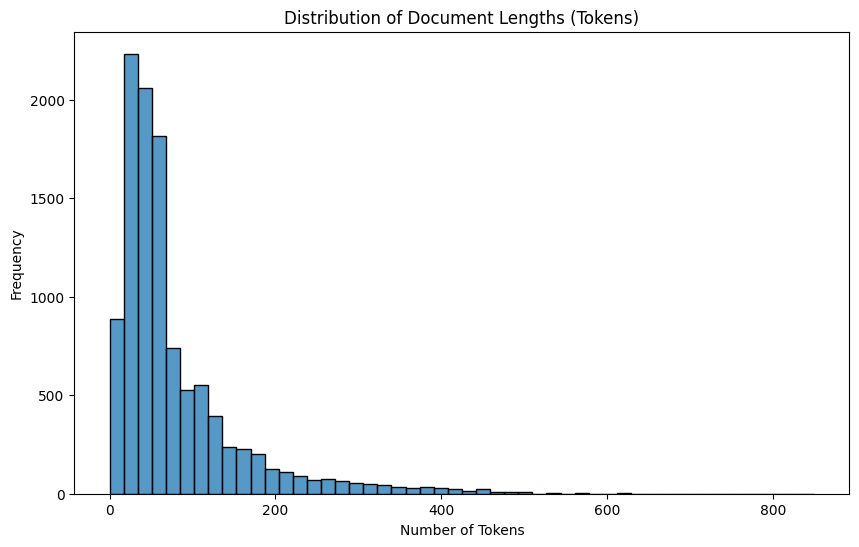

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate document lengths (in tokens)
doc_lengths = [len(doc) for doc in processed_docs]

# Create a DataFrame
df = pd.DataFrame({'doc_length': doc_lengths})

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['doc_length'], bins=50)
plt.title('Distribution of Document Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

**3.2 Most Frequent Words (Excluding Stop Words)**
> Approach:
Flatten the list of tokens from all documents.
Count word frequencies using collections.Counter.
Visualize the top 10 words with a bar chart.

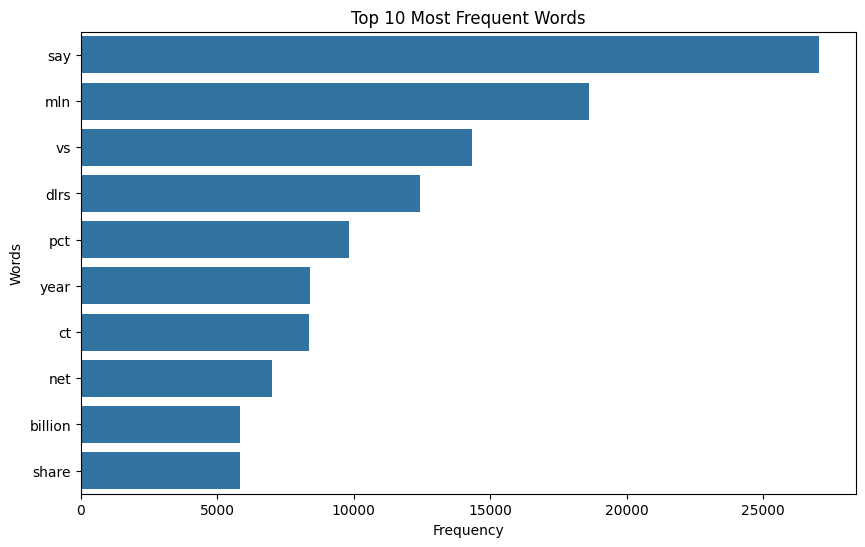

In [6]:
from collections import Counter

# Flatten tokens
all_tokens = [token for doc in processed_docs for token in doc]

# Count word frequencies
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(10)

# Prepare data for visualization
words, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

**3.3 Entity Frequency**
> Approach:
Use `spaCy’s` NER to extract entities (e.g., PERSON, ORGANIZATION, DATE).
Count entity frequencies and visualize with a bar chart.

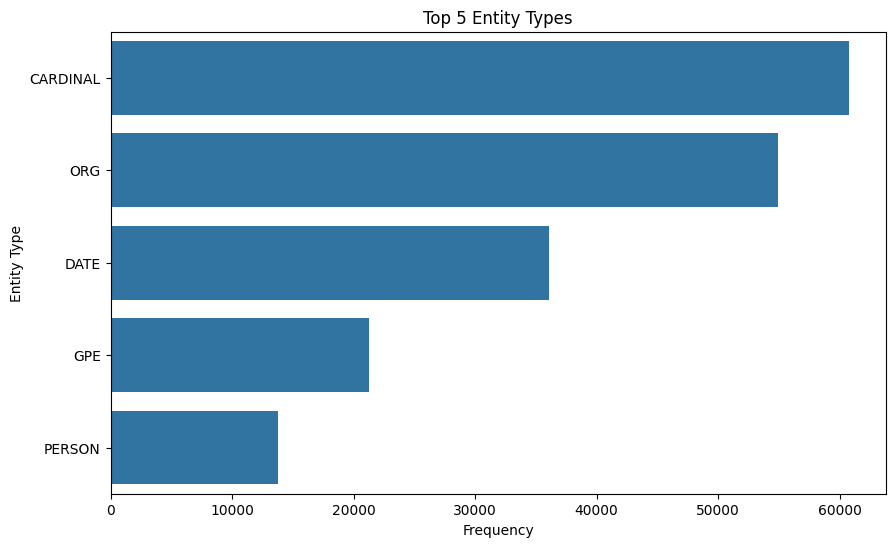

In [8]:
# Re-enable NER for entity extraction
nlp = spacy.load("en_core_web_sm")

# Extract entities
entities = []
for doc in documents:  # Process raw documents
    doc_nlp = nlp(doc)
    entities.extend([(ent.text, ent.label_) for ent in doc_nlp.ents])

# Count entity types
entity_types = [label for _, label in entities]
entity_freq = Counter(entity_types)

# Prepare data for visualization
entity_labels, entity_counts = zip(*entity_freq.most_common(5))

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(entity_counts), y=list(entity_labels))
plt.title('Top 5 Entity Types')
plt.xlabel('Frequency')
plt.ylabel('Entity Type')
plt.show()

## Part 2: Information Extraction & Summarization
- Objective: Extract meaningful entities or features from text and generate document summaries.


**Step 1: Entity & Information Extraction**
> Objective: Extract meaningful entities/features using two approaches:
- Rule-Based Extraction (using regex for dates and metrics).
- NER Using NLP Libraries (spaCy for named entities).

**1.1 Rule-Based Extraction (Regex)**
> Approach:
Extract dates (e.g., "20 June 2025", "2025-06-20") and metrics (e.g., "10%", "$500 million") using regex patterns.
Use Python’s re module for pattern matching.

**1.2 NER Using spaCy**
> Approach:
Use spaCy’s pre-trained en_core_web_sm model to extract named entities (e.g., PERSON, ORGANIZATION, GPE, DATE).
Store results in a structured JSON format.

In [11]:
import re

import json

# Rule-Based Extraction (Dates and Metrics)
def rule_based_extraction(text):
    # Regex for dates (e.g., "20 June 2025", "2025-06-20")
    date_pattern = r'\b(\d{1,2}\s(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}|\d{4}-\d{2}-\d{2})\b'
    # Regex for metrics (e.g., "10%", "$500 million")
    metric_pattern = r'\b(?:\$\d+(?:\.\d+)?\s?(?:million|billion|%)|\d+(?:\.\d+)?%)\b'

    dates = re.findall(date_pattern, text)
    metrics = re.findall(metric_pattern, text)
    return {"dates": dates, "metrics": metrics}

# NER Extraction with spaCy
def ner_extraction(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return {
        "PERSON": [ent[0] for ent in entities if ent[1] == "PERSON"],
        "ORGANIZATION": [ent[0] for ent in entities if ent[1] == "ORG"],
        "GPE": [ent[0] for ent in entities if ent[1] == "GPE"],
        "DATE": [ent[0] for ent in entities if ent[1] == "DATE"]
    }

# Process documents
extracted_data = []
for doc in documents[:1000]:
    rule_based = rule_based_extraction(doc)
    ner_based = ner_extraction(doc)
    extracted_data.append({
        "rule_based": rule_based,
        "ner_based": ner_based
    })

# Save results to JSON
with open("extracted_entities.json", "w") as f:
    json.dump(extracted_data, f, indent=2)


**Step 2: Summarization**
> Objective: Implement one summarization technique. I’ll choose Abstractive Summarization using Hugging Face’s BART model for its robust performance in generating coherent summaries.

>Approach:
Use facebook/bart-large-cnn from Hugging Face Transformers.
Summarize a subset of documents (first 5 for demonstration) with a max length of 100 words.
Handle long documents by truncating input to the model’s max token limit (1024 tokens for BART).

In [12]:
from transformers import pipeline

# Initialize BART summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Summarize documents
summaries = []
for doc in documents[:5]:  # Limit to 5 documents
    # Truncate to 1024 tokens (BART's max input length)
    doc_truncated = doc[:4000]  # Rough estimate for ~1024 tokens
    try:
        summary = summarizer(doc_truncated, max_length=100, min_length=30, do_sample=False)
        summaries.append(summary[0]["summary_text"])
    except Exception as e:
        summaries.append(f"Error summarizing: {str(e)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


**Step 3: Qualitative Evaluation**
> Objective: Provide examples to show accuracy and coherence of extracted entities and summaries.

In [13]:


# Print qualitative examples
for i, (doc, summary, extraction) in enumerate(zip(documents[:5], summaries, extracted_data[:5])):
    print(f"\nDocument {i+1} (First 100 chars): {doc[:100]}...")
    print(f"Summary: {summary}")
    print(f"Extracted Entities: {json.dumps(extraction, indent=2)}")


Document 1 (First 100 chars): ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Ja...
Summary: Error summarizing: index out of range in self
Extracted Entities: {
  "rule_based": {
    "dates": [],
    "metrics": []
  },
  "ner_based": {
    "PERSON": [
      "Tom\n  Murtha",
      "Paul Sheen",
      "Lawrence Mills",
      "John Button",
      "Button",
      "Michael Smith",
      "Makoto\n  Kuroda"
    ],
    "ORGANIZATION": [
      "Reuter",
      "Unofficial",
      "Matsushita Electric\n  Industrial Co Ltd &",
      "U.S. Products",
      "U.S. Retaliation",
      "textile exporters &lt;Taiwan Safe Group>",
      "the Federation of Hong Kong Industry",
      "Liberal Democratic Party",
      "International Trade and\n  Industry",
      "MITI"
    ],
    "GPE": [
      "U.S.",
      "Japan",
      "U.S.",
      "Japan",
      "U.S.",
      "Tokyo",
      "U.S.",
      "Japan",
      "U.S.",
      "Tokyo",
      "Taiwan",
      "U.S

In [17]:
!pip install rouge_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


# Generated summaries (from your output, excluding Document 1)
generated_summaries = [
    "Survey of 19 provinces and seven cities showed vermin consume between seven and 12 pct of China's grain stocks. Each year 1.575 mln tonnes, or 25 pct, of China's fruit output are left to rot.",
    "The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen. MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres.",
    "Thailand's trade deficit widened to 4.5 billion baht in the first quarter of 1987. The country's oil import bill, however, fell 23 pct in the same period due to lower oil prices.",
    "Indonesia expects crude palm oil (CPO) prices to rise sharply to between 450 and 550 dlrs a tonne FOB this year. Prices of Malaysian and Sumatran CPO are now around 332 dlRS a tonnne CIF for delivery in Rotterdam."
]

# Hypothetical reference summaries
reference_summaries = [
    "A survey in China found that vermin destroy 7–12% of grain stocks annually, while 25% of fruit production (1.575 million tonnes) rots each year.",
    "Japan’s MITI plans to reduce its year 2000 energy demand forecast to 550 million kilolitres due to industrial changes and a stronger yen.",
    "In Q1 1987, Thailand’s trade deficit grew to 4.5 billion baht, but its oil import costs dropped 23% due to lower global oil prices.",
    "Indonesia anticipates crude palm oil prices rising to 450–550 dollars per tonne FOB this year, compared to current Malaysian/Sumatran prices of 332 dollars per tonne CIF in Rotterdam."
]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store scores
rouge_scores_list = []
bleu_scores = []

# Evaluate each summary
for gen, ref in zip(generated_summaries, reference_summaries):
    # ROUGE scores
    rouge_scores = scorer.score(ref, gen)
    rouge_scores_list.append(rouge_scores)

    # BLEU score
    reference_tokens = [word_tokenize(ref.lower())]
    generated_tokens = word_tokenize(gen.lower())
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # 4-gram BLEU
    bleu_scores.append(bleu_score)

# Compute average scores
avg_rouge1_f1 = sum(scores['rouge1'].fmeasure for scores in rouge_scores_list) / len(rouge_scores_list)
avg_rouge2_f1 = sum(scores['rouge2'].fmeasure for scores in rouge_scores_list) / len(rouge_scores_list)
avg_rougeL_f1 = sum(scores['rougeL'].fmeasure for scores in rouge_scores_list) / len(rouge_scores_list)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Print results
print("Average ROUGE Scores:")
print(f"ROUGE-1 F1: {avg_rouge1_f1:.4f}")
print(f"ROUGE-2 F1: {avg_rouge2_f1:.4f}")
print(f"ROUGE-L F1: {avg_rougeL_f1:.4f}")
print(f"Average BLEU Score: {avg_bleu:.4f}")

# Detailed scores for each summary
for i, (rouge_scores, bleu) in enumerate(zip(rouge_scores_list, bleu_scores), 2):
    print(f"\nDocument {i} Scores:")
    for metric, scores in rouge_scores.items():
        print(f"{metric}: Precision={scores.precision:.4f}, Recall={scores.recall:.4f}, F1={scores.fmeasure:.4f}")
    print(f"BLEU: {bleu:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Average ROUGE Scores:
ROUGE-1 F1: 0.5275
ROUGE-2 F1: 0.1860
ROUGE-L F1: 0.4107
Average BLEU Score: 0.0656

Document 2 Scores:
rouge1: Precision=0.4211, Recall=0.6154, F1=0.5000
rouge2: Precision=0.0811, Recall=0.1200, F1=0.0968
rougeL: Precision=0.2632, Recall=0.3846, F1=0.3125
BLEU: 0.0000

Document 3 Scores:
rouge1: Precision=0.2821, Recall=0.4583, F1=0.3492
rouge2: Precision=0.0526, Recall=0.0870, F1=0.0656
rougeL: Precision=0.1795, Recall=0.2917, F1=0.2222
BLEU: 0.0000

Document 4 Scores:
rouge1: Precision=0.5429, Recall=0.7308, F1=0.6230
rouge2: Precision=0.3235, Recall=0.4400, F1=0.3729
rougeL: Precision=0.4857, Recall=0.6538, F1=0.5574
BLEU: 0.1441

Document 5 Scores:
rouge1: Precision=0.5641, Recall=0.7333, F1=0.6377
rouge2: Precision=0.1842, Recall=0.2414, F1=0.2090
rougeL: Precision=0.4872, Recall=0.6333, F1=0.5507
BLEU: 0.1181


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


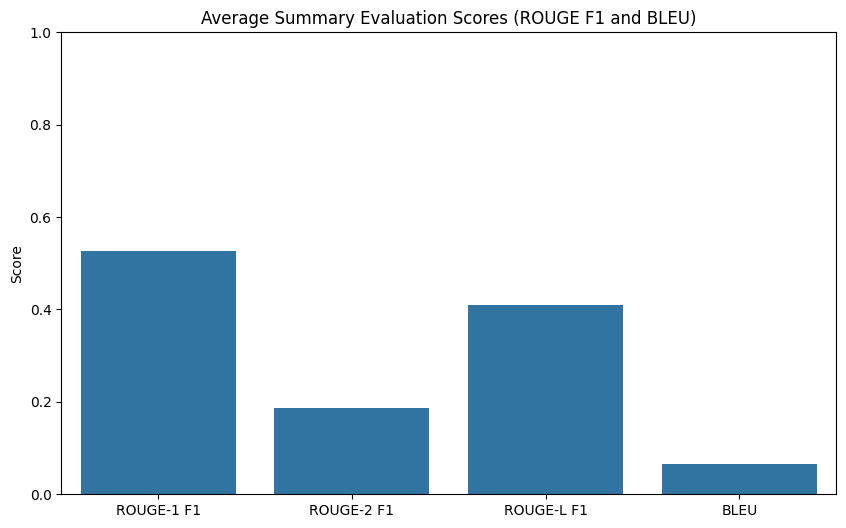

In [18]:
# prompt: bar gragh for ROUGE valus

# Data for the bar chart
metrics = ['ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1', 'BLEU']
values = [avg_rouge1_f1, avg_rouge2_f1, avg_rougeL_f1, avg_bleu]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values)
plt.title('Average Summary Evaluation Scores (ROUGE F1 and BLEU)')
plt.ylabel('Score')
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.show()

## **Part 3: Agentic System Design**
> **Objective**: Conceptualize an AI agent that uses your extraction and summarization capabilities to solve a real-world problem.

> **Deliverable**: Describe and design an agent system including:

### **News Aggregator Agent**
### **Scenario**
I design an AI News Aggregator Agent that continuously monitors multiple news sources (websites, RSS feeds, social media, etc.) and produces concise summaries of breaking news. For example, the agent might run on a daily schedule or respond to user queries like “Summarize today’s news about climate change.” It fetches articles from news APIs or feeds, extracts the most relevant information, and then summarizes it into a digestible report. This tackles information overload by giving users timely, curated news summaries. Similar systems use RSS and social feeds to gather content
reddit.com
 or schedule periodic fetches via News APIs
hbayraktar.medium.com
, ensuring the agent stays up-to-date.

### **Agent’s Goal**
- **Deliver concise, accurate news summaries**. The agent aims to keep the user informed of major events by summarizing multiple news articles into a brief report.
- **Filter by relevance**. It should highlight only the most important or relevant news on the user’s topics of interest (e.g. tech, finance, world events).
- **Reduce duplication**. By comparing articles on the same story, the agent avoids repeating the same facts, focusing on new or corroborated information .

### **Agent’s Tools**
- **News Retrieval (Collection)**: Interfaces to pull news content. This could be through RSS feeds, specialized news APIs (like NewsAPI.org), or web-scraping. For example, an implementation might schedule jobs to “fetch U.S. news using NewsAPI” every few hours. These tools supply the raw articles.
- **Content Extraction Module**: An NLP or LLM-based extractor that scans each article for key facts or sentences. In multi-article summarization, systems often extract relevant sentences from each source as input. This tool might perform named-entity recognition or answer specific sub-questions (e.g. “Who is involved? What happened?”) to pinpoint the critical information in each article. Extractive summarization techniques identify the most important sentences, which are then used in the final summary.
- **Summarization Module**: A summarization LLM (either extractive or abstractive) that condenses the extracted content into a shorter form. Summarization “creates a shorter version of a document or article that captures all the important information”. For instance, after extraction, the agent feeds those key points into a transformer model that generates an abstractive summary. This module might be a Hugging Face transformer or GPT-based model fine-tuned for news summarization.
- **Filtering/Indexing (Optional)**: A vector database or indexing system to store past articles or embeddings. This can help filter out already-seen news and personalize content. For example, one system “filter[s] content based on personal interests and remove[s] noises (via [a] vector database)”. By indexing article embeddings, the agent can check if a story is new or related to previous news.

### **Reasoning and Planning Strategy**
- **Query Parsing**: If the agent is interactive, it first parses the user’s request (or the scheduled task’s focus). For example, it may extract keywords or topics from a user’s question (“climate change”, “elections”, etc.) or identify trending topics. This step translates the user’s intent into a structured query for the retrieval stage.
- **Document Retrieval**: The agent uses the parsed query to search news sources. This could be done via news APIs (e.g. passing keywords to NewsAPI.org) or by performing web searches. Modern designs often use **retrieval-augmented generation (RAG)**: an orchestration layer (such as LangChain) takes the user’s query, uses retrieval tools (like search or a vector-index lookup) to fetch relevant documents, and then passes those documents to the LLM
stackoverflow.blog In our agent, the Retrieval tool returns up-to-date news articles relevant to the query or topic. This ensures the agent is using the latest information, addressing one drawback of static LLM knowledge.
- **Extraction and Summarization Chaining:** For each retrieved article, the agent chains tools as follows: (1) The extraction module processes the article to pull out salient sentences or facts. (2) The summarization module takes those extracted pieces and generates a concise summary. The outputs from multiple articles can then be merged or ranked. This might involve a second-level abstraction: for instance, summarizing each article individually and then combining the summaries into a single final report. Multi-document systems often compare and rank extracted sentences across sources to form a cohesive summary.
-** Answer Formation**: Finally, the agent compiles the processed output into the final answer. It may list key news items with brief descriptions, highlight the main event, and cite sources as needed. If the user asked a specific question, the agent answers based on the synthesized summaries. Otherwise, it might simply present the top K stories. At all stages, the agent can do consistency checks or ask the LLM to verify if the summary covers the query fully (a “reflection” step)

- **Memory (Optional)**: A memory component stores past interactions or results to improve efficiency and personalization. For example, the agent could remember which stories it already summarized today, so it doesn’t repeat them. It could also store user preferences (e.g. favorite topics or sources) to prioritize certain news. As IBM notes, “memory helps the agent retain and retrieve past interactions, enabling contextual responses”. In practice, this could be a database of recent article IDs or user profile data. If implemented, memory would reduce duplication and allow the agent to build on prior knowledge (e.g. “you asked about elections last week – here are the latest updates”).

### **Architecture (Pseudocode)**




```
# Pseudocode for the News Aggregator Agent workflow

def news_aggregator_agent(query):
    topics = parse_query(query)           # Extract keywords or topics from user request
    articles = fetch_news(topics)        # Retrieve relevant news (via RSS/API/search)
    summaries = []

    for article in articles:
        info = extract_key_content(article)    # Extract salient sentences/facts
        summary = summarize_content(info)      # Summarize extracted content
        summaries.append(summary)

    final_report = merge_summaries(summaries)   # Combine or rank summaries
    return final_report

# Helper functions (conceptual):
# parse_query: NLP parse of user input.
# fetch_news: uses News API or search based on topics.
# extract_key_content: NLP extractor (sentence ranking, NER, QA).
# summarize_content: calls an LLM summarizer (abstractive or extractive).
# merge_summaries: aggregates multiple summaries into one answer.
```
This flow shows how tools are chained: first parsing and retrieval, then extraction and summarization, and finally aggregation. For example, in a RAG-based system, fetch_news and extract_key_content would involve vector-search or API calls and then grounding the LLM with the retrieved text. Throughout, the agent’s planning logic ensures each step feeds into the next. For instance, it might adaptively decide how many articles to summarize or whether to ask the LLM follow-up questions if the query is unclear (a ReAct-like strategy).

Each component can be implemented as an LLM “tool” or external function, with the agent’s orchestrator (e.g. LangChain or a custom controller) directing calls. Tools are chained so that the output of fetch_news becomes the input of extract_key_content, whose output is fed into summarize_content. Finally, merge_summaries produces the answer. This modular design follows best practices for LLM agents, where an orchestration layer interacts with distinct components.

**Example Decision Logic**: On receiving a query, the agent first identifies topic keywords. If the query is specific (e.g. “latest on [topic]”), it uses those directly; if it’s broad (e.g. “today’s news”), it might select trending topics via a quick pre-search. Then it fetches, say, the top 10 articles from a news API for those topics. If too many articles overlap, it can cluster them to avoid duplication. Next, it runs the extraction tool to get key points from each article (for instance, by prompting the LLM: “List the 3 most important facts from this article:”). Then it prompts the summarization tool to condense those facts into a short paragraph. Finally, it might rank the article-summaries by relevance and concatenate them. Throughout, the agent ensures context consistency (it can refer back to memory of past queries or news to filter out old information).

**Memory Component:** In a continuous setting, the agent benefits from memory. It can store metadata of previously processed articles (titles, URLs, embeddings) so that it doesn’t re-summarize the same story. It can also log user feedback or preferences (e.g. “user likes sports news”), so future queries prioritize relevant sources. As noted, well-structured memory “ensures continuity” and helps the agent provide consistent, informed outputs
. In summary, memory acts as a short-term cache of news events and user context, improving efficiency and personalization.


### **Summery**
Overall, this design combines retrieval, extraction, and summarization in a pipeline. It leverages external tools (news APIs, databases, NLP models) under the control of an LLM agent. Each step in the pipeline is backed by techniques described in literature – for instance, multi-document news summarization research advocates extracting and ranking sentences from each source
mdpi.com
, and LLM orchestration guides such as LangChain emphasize using retrieval tools to ground the model
stackoverflow.blog
. By chaining these components with clear logic and optional memory, the agent can reliably answer news queries with fresh, concise summaries.